In [2]:
# ==== One-shot Kaggle + Drive setup (Colab) ====
MODE = "dataset"  # "dataset" or "competition"
KAGGLE_REF = "jonathanoheix/face-expression-recognition-dataset"
DRIVE_DATA_DIR = "/content/drive/MyDrive/kaggle_data/face-expression-recognition-dataset"
MAKE_WORKING_COPY = True
FORCE_DOWNLOAD = False  # set True to refresh even if cached

# --------------------------------------------------------------------------
import os, sys, zipfile, shutil, textwrap, json, subprocess
from pathlib import Path

def pip_install(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

pip_install("kaggle")

from google.colab import drive
try:
    drive.mount("/content/drive")
except Exception:
    # If you see "already mounted", that's fine. Force remount if you want.
    drive.mount("/content/drive", force_remount=True)


# --- Prepare target dirs ---
DRIVE_DATA_DIR = Path(DRIVE_DATA_DIR)
DRIVE_DATA_DIR.mkdir(parents=True, exist_ok=True)

WORK_DIR = Path("/content/kaggle_work")

print("\nPaths:")
print("  Persistent (Drive):", DRIVE_DATA_DIR)
print("  Working (Runtime) :", WORK_DIR if MAKE_WORKING_COPY else "(disabled)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Paths:
  Persistent (Drive): /content/drive/MyDrive/kaggle_data/face-expression-recognition-dataset
  Working (Runtime) : /content/kaggle_work


In [3]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install torch
! pip install torchvision
! pip install torchmetrics
! pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.7 MB/s eta 0:00:00


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

import time

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Enable cuDNN optimizations
    torch.backends.cudnn.benchmark = True

    # AMP setup
    use_amp = True
    scaler = torch.amp.GradScaler('cuda')
else:
    print("⚠️  WARNING: No GPU! Go to Runtime -> Change runtime type -> T4 GPU")
    use_amp = False
    scaler = None

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [6]:
batch_size = 128

data_dir = DRIVE_DATA_DIR / 'images'

# Định nghĩa cho tập TRAIN (Có Augmentation)
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),

    # Agument data
    transforms.RandomHorizontalFlip(p=0.5), # 50% cơ hội lật ảnh
    transforms.RandomRotation(10),           # Xoay tối đa 10 độ
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Dịch chuyển ảnh nhẹ

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Định nghĩa cho tập TEST (Khong co Augmentation)
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/validation", transform=transform_test)

train_loader = DataLoader(
    batch_size=batch_size,
    dataset=train_dataset,
    shuffle=True,
    num_workers=2,  # Reduced for Colab stability
    pin_memory=True
)
test_loader = DataLoader(
    batch_size=batch_size,
    dataset=test_dataset,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"Test: {len(test_dataset)} images, {len(test_loader)} batches")

Train: 28822 images, 226 batches
Test: 7066 images, 56 batches


In [7]:
all_labels = train_dataset.targets
unique_labels, counts = np.unique(all_labels, return_counts=True)

total_samples = len(train_dataset)
num_classes = len(unique_labels)

weights = [total_samples / (num_classes * c) for c in counts]
class_weights = torch.FloatTensor(weights).to(device)

print(f"Số lượng mẫu đếm được: {counts}")
print(f"Trọng số tương ứng: {weights}")

Số lượng mẫu đếm được: [3993  436 4103 7164 4982 4939 3205]
Trọng số tương ứng: [np.float64(1.031161675789775), np.float64(9.443643512450851), np.float64(1.003516590647958), np.float64(0.5747387732312356), np.float64(0.8264609737913632), np.float64(0.8336563214068782), np.float64(1.2846891018497884)]


In [10]:
x, y = train_dataset[0]
print(x.shape)

torch.Size([1, 48, 48])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


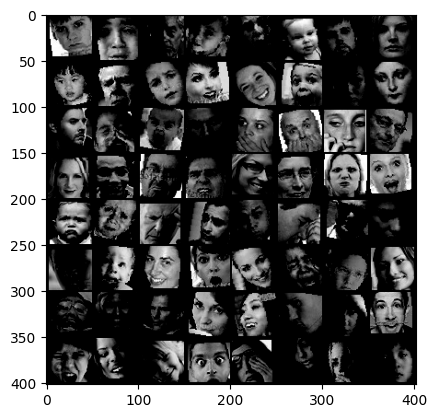

In [11]:
def img_show(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# get some random image
data_iter = iter(train_loader)
images, labels = next(data_iter)

labels

img_show(torchvision.utils.make_grid(images))

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Building blocks of convolutional neural network.
        Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 7 (i.e 7 emotions).
        """
        super(CNN, self).__init__()

        # Các lớp trích xuất đặc trưng (Feature Extraction)
        """
        Conv2d: Nhìn và tìm đặc trưng.

        BatchNorm2d: Chuẩn hóa dữ liệu cho lớp sau dễ học.

        ReLU: Loại bỏ các giá trị âm (không quan trọng).

        MaxPool2d: Tóm tắt lại những gì vừa nhìn thấy.

        Dropout: Ép mô hình học kĩ, không học vẹt.
        """

        self.features = nn.Sequential(
            # Block 1: 48x48 -> 24x24
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2nd convolution layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3nd convolution layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 4nd convolution layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1,1)) # Gom về 256 con số
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: Input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = self.features(x) # Output: (Batch, 16, 1, 1)
        x = torch.flatten(x, 1) # Biến thành vector: (Batch, 16)
        x = self.fc(x) # Dự đoán: (Batch, 10)

        return x

In [9]:
class ResBlock(nn.Module):
    """
    Basic residual block with two conv layers and skip connection.

    Structure:
        x -> Conv -> BN -> ReLU -> Conv -> BN -> + -> ReLU -> out
        |_______________________________________|
                    (skip connection)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        # Lop Conv 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Lop Conv 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)


        # Đường tắt (Skip Connection)
        # Nếu số kênh thay đổi hoặc stride > 1, ta cần dùng Conv 1x1 để khớp kích thước
        self.shortcut = nn.Identity() # Changed from nn.Sequential() to nn.Identity() for robustness
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Cộng tín hiệu cũ (identity) vào kết quả mới
        out += self.shortcut(identity)
        out = F.relu(out)

        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, num_classes = 7) -> None:
        super(ResNet, self).__init__()

        self.in_channels = 64

        # Lớp đầu vào: Ảnh xám 1 kênh -> 64 kênh
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Các cụm Residual Blocks
        # Mỗi layer sẽ tăng số kênh và giảm kích thước ảnh (stride=2)
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)

        # Thay vì dùng Flatten() -> Linear rất nặng, ta dùng Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Lớp phân loại cuối cùng
        self.fc = nn.Sequential(
            nn.Dropout(0.5), # Chống overfitting mạnh
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []

        # Block đầu tiên của cụm có thể thay đổi stride và số kênh
        layers.append(ResBlock(in_channels, out_channels, stride))

        # Các block sau đó giữ nguyên số kênh
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

In [12]:
# model = CNN(in_channels=1, num_classes=7).to(device)
# model_path = f"{DRIVE_DATA_DIR}/emotion_model.pth"

model = ResNet(num_classes=7).to(device)
model_path = f"{DRIVE_DATA_DIR}/emotion_resnet_model.pth"

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
model.apply(init_weights)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [14]:
# define loss function
loss = nn.CrossEntropyLoss(weight=class_weights)

# define optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Nếu Val Accuracy không tăng sau 5 epoch, giảm LR đi một nửa -> chọn accuracy cang lon con tot
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
num_epochs = 30  # Reduced - ResNet converges faster
best_accuracy = 0.0
start_epoch = 0

# Resume from checkpoint if exists (handles Colab disconnects)
checkpoint_path = f"{DRIVE_DATA_DIR}/checkpoint_resnet.pth"

if Path(checkpoint_path).exists():
    print("📂 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch'] + 1
    best_accuracy = checkpoint['best_accuracy']
    if use_amp and 'scaler' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler'])
    print(f"✅ Resumed from epoch {start_epoch}, best acc: {best_accuracy:.2f}%")

for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, leave=True)

    for data, targets in loop:
        data = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast('cuda'):
                scores = model(data)
                loss_value = loss(scores, targets)
            scaler.scale(loss_value).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            scores = model(data)
            loss_value = loss(scores, targets)
            loss_value.backward()
            optimizer.step()

        running_loss += loss_value.item()
        _, predictions = scores.max(1)
        correct_train += (predictions == targets).sum().item()
        total_train += targets.size(0)

        loop.set_description(f"Loss: {loss_value.item():.4f}")

    train_acc = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    # --- EVALUATION ---
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            if use_amp:
                with torch.amp.autocast('cuda'):
                    scores = model(data)
                    v_loss = loss(scores, targets)
            else:
                scores = model(data)
                v_loss = loss(scores, targets)

            val_loss += v_loss.item()
            _, predictions = scores.max(1)
            correct_val += (predictions == targets).sum().item()
            total_val += targets.size(0)

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(test_loader)

    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}   | Val Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")
    print(f"⏱️  Epoch time: {epoch_time:.1f}s")

    # Save checkpoint every epoch (to Google Drive - survives disconnect)
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'best_accuracy': best_accuracy,
    }
    if use_amp:
        checkpoint['scaler'] = scaler.state_dict()
    torch.save(checkpoint, checkpoint_path)

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"🏆 Saved best model: {val_acc:.2f}%")

print(f"\n✅ Training complete! Best accuracy: {best_accuracy:.2f}%")


Epoch 1/30


Loss: 2.0816:   3%|▎         | 7/226 [06:24<3:27:48, 56.93s/it]

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

model = CNN(in_channels=1, num_classes=7).to(device)

model.load_state_dict(torch.load(model_path))

model.eval()
all_preds = []
all_labels = []

categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("--- EVALUATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
print(df_cm)


--- EVALUATION REPORT ---
              precision    recall  f1-score   support

       angry       0.54      0.55      0.54       960
     disgust       0.46      0.74      0.56       111
        fear       0.52      0.42      0.46      1018
       happy       0.87      0.81      0.84      1825
     neutral       0.56      0.63      0.60      1216
         sad       0.50      0.52      0.51      1139
    surprise       0.73      0.76      0.75       797

    accuracy                           0.63      7066
   macro avg       0.60      0.63      0.61      7066
weighted avg       0.64      0.63      0.63      7066

          angry  disgust  fear  happy  neutral  sad  surprise
angry       525       42    83     28      122  134        26
disgust      15       82     2      1        5    3         3
fear        150       16   424     28      123  181        96
happy        62        4    32   1483      120   73        51
neutral      81        5    58     80      769  191        32
sad  

In [11]:
# export model to TorchScript

model_path_ts = f"{DRIVE_DATA_DIR}/emotion_model_ts.pth"

# Instantiate the model with the correct architecture
model = CNN(in_channels=1, num_classes=7)
# Load the state dictionary into the model
model.load_state_dict(torch.load(model_path, map_location="cpu"))

model.eval()

example = torch.randn(1, 1, 48, 48)  # chỉnh đúng input
ts = torch.jit.trace(model, example)
ts = torch.jit.freeze(ts)
ts.save(model_path_ts)